# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor as catbreg
from lightgbm import LGBMRegressor as lgbmreg
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

In [2]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


Видим что встречаются нулевые значения цены, удаляем их

In [6]:
df = df[df['Price'] != 0]

Удалим признаки, которые не прриносят полезной информации в модель

In [7]:
df = df.drop(['DateCrawled',
              'DateCreated',
              'NumberOfPictures',
              'PostalCode',
              'LastSeen'], axis=1)

Проверим датасет на пропуски

In [8]:
df.isna().sum().sort_values()

Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
Gearbox              17355
Model                17521
FuelType             29459
VehicleType          33750
NotRepaired          65866
dtype: int64

Заполним пропуски строковым значением 'Unknown'

In [9]:
df[['Model', 'Gearbox', 'FuelType', 'VehicleType',
    'NotRepaired', 'Brand']] = df[['Model',
                          'Gearbox', 'FuelType', 'VehicleType',
                          'NotRepaired', 'Brand']].fillna(value='Unknown')

In [10]:
df.isna().sum().sort_values()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

Посмотрим на распределение целевого признака

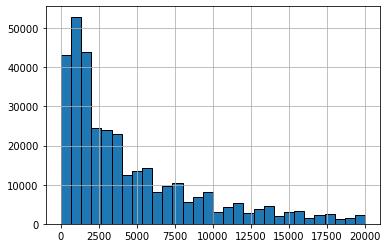

In [11]:
df['Price'].hist(bins=30, edgecolor='k')

Распределение скошено вправо и есть длинный хвост вправо, в сторону большей цены
Не будем его усекать, скорее всего это не выбросы и не ухудшит модель

In [12]:
df.duplicated().sum()

26158

Избавимся от дубликатов

In [13]:
df = df[~df.duplicated()]

In [14]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired'],
      dtype='object')

Для преобразования буквенных категорий в понятные модели числовые данные используем LabelEncoder

In [15]:
cat_columns = ['VehicleType',
                'Gearbox', 'Model', 'FuelType',
                'Brand', 'NotRepaired']
label_encoder = LabelEncoder()

for col in cat_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [16]:
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,0,1993,2,0,117,150000,0,7,38,0
1,18300,3,2011,2,190,26,125000,5,3,1,2
2,9800,7,2004,1,163,118,125000,8,3,14,0
3,1500,6,2001,2,75,117,150000,6,7,38,1
4,3600,6,2008,2,69,102,90000,7,3,31,1


## Обучение моделей

Выделим признаки и целевой признак

In [17]:
target = df['Price']
features = df.drop(['Price'] , axis=1)

Выделим тестовую подвыборку

In [18]:
features_train, features_test, target_train, target_test = train_test_split(
    features,
    target,
    test_size=0.25,
    random_state=17)

In [19]:
print(f'Размер Train: features {features_train.shape} target {target_train.shape}')
print(f'Размер Test: features {features_test.shape} target {target_test.shape}')

Размер Train: features (238079, 10) target (238079,)
Размер Test: features (79360, 10) target (79360,)


### LGBM Regresspor

Обучим модель градиентного бустинга LGBM Regressor

In [20]:
booster = lgb.LGBMRegressor(iterations=100, max_depth=15, learning_rate=0.2)

In [21]:
%%time
booster.fit(features_train,
            target_train,
            verbose=50)

CPU times: user 24 s, sys: 207 ms, total: 24.2 s
Wall time: 24.4 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', iterations=100, learning_rate=0.2,
              max_depth=15, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [22]:
%%time
booster_pred = booster.predict(features_test)

CPU times: user 514 ms, sys: 3.32 ms, total: 517 ms
Wall time: 500 ms


In [23]:
print(mean_squared_error(booster_pred, target_test) ** 0.5)

1716.7534153254537


Лучший параметр подобрали в ручную, GridSerch сделает RMSE меньше, но это займет намного больше времени

### Linear regression

Обучим модель линейной регрессии

In [24]:
%%time
lr = LinearRegression().fit(features_train, target_train)

CPU times: user 69.9 ms, sys: 13 ms, total: 82.9 ms
Wall time: 89.1 ms


In [25]:
%%time
scores= np.sqrt(-cross_val_score(lr,
                                 features_train,
                                 target_train,
                                 scoring="neg_mean_squared_error",
                                 cv = 5))


CPU times: user 683 ms, sys: 505 ms, total: 1.19 s
Wall time: 1.19 s


In [26]:
print('Train scores:')
print('rmse = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores,
                                                            scores.mean(),
                                                            scores.std()))
print()
print('Test scores:')
scores= np.sqrt(-cross_val_score(lr,
                                 features_test,
                                 target_test,
                                 scoring="neg_mean_squared_error",
                                 cv = 5))
print('rmse = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores,
                                                            scores.mean(),
                                                            scores.std()))

Train scores:
rmse = [4035.9190509  4041.02251539 4068.75557683 4032.74756055 4080.82554443] 
mean score = 4051.85405 +/- 19.29411

Test scores:
rmse = [4014.87205474 4063.67127598 4046.39546705 4047.46282857 4114.22567039] 
mean score = 4057.32546 +/- 32.54821


### CatBoost regression

Обучим модель градиентного бустинга CatBoost регрессию

In [27]:
catb = catbreg(loss_function="RMSE", verbose=100, n_estimators=500, depth=10)

In [28]:
%%time
catb.fit(features_train, target_train)

0:	learn: 4430.3786691	total: 246ms	remaining: 2m 2s
100:	learn: 1972.8905015	total: 21.1s	remaining: 1m 23s
200:	learn: 1804.7036566	total: 41.9s	remaining: 1m 2s
300:	learn: 1739.2655693	total: 1m 2s	remaining: 41.4s
400:	learn: 1697.1774177	total: 1m 23s	remaining: 20.6s
499:	learn: 1666.6081723	total: 1m 44s	remaining: 0us
CPU times: user 1min 35s, sys: 8.83 s, total: 1min 44s
Wall time: 1min 46s


In [29]:
%%time
catb_pred = catb.predict(features_test)

CPU times: user 256 ms, sys: 28 ms, total: 284 ms
Wall time: 226 ms


In [30]:
print(mean_squared_error(catb_pred, target_test) ** 0.5)

1724.1295901549004


Модель можно улучшать, но временные затраты при одинаковых оценках с lgbm будут больше у catboost

## Анализ моделей

Сравним результаты

In [37]:
data = [[24.4, 0.5, 1716],
       [0.09, 1.19, 4057],
       [106, 0.23, 1724]]
model_name = ['LGBMRegresspor', 'LinearRegression', 'CatBoostRegression']
col_name = ['time_s_fit','time_s_pred', 'score']

In [38]:
pd.DataFrame(data=data, index=model_name, columns=col_name)

,time_s_fit,time_s_pred,score
LGBMRegresspor,24.40,0.50,1716
LinearRegression,0.09,1.19,4057
CatBoostRegression,106.00,0.23,1724


Модели градиентного бустинга гораздо лучше линейных моделей по оценкам, но время нахождения лучших параметров и время обучения у них больше.
Стоит отметить, что при одинаковых оценках LGBM обучается быстрее, а предсказание делает чуть дольше, линейная модель по времени предсказания самая долгая.